<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/exploration/Exploration16_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation map으로 도로 이미지 만들기

In [4]:
#! pip install opencv-contrib-python==4.5.3.56
#! pip install opencv-python==4.5.3.56

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56.1 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [1]:
import cv2

print(cv2.__version__)

4.6.0


## 1. 데이터 불러오기

데이터를 불러옵니다. cityspace 데이터는 1000개가 있습니다.  
6개를 먼저 확인해 봅시다.

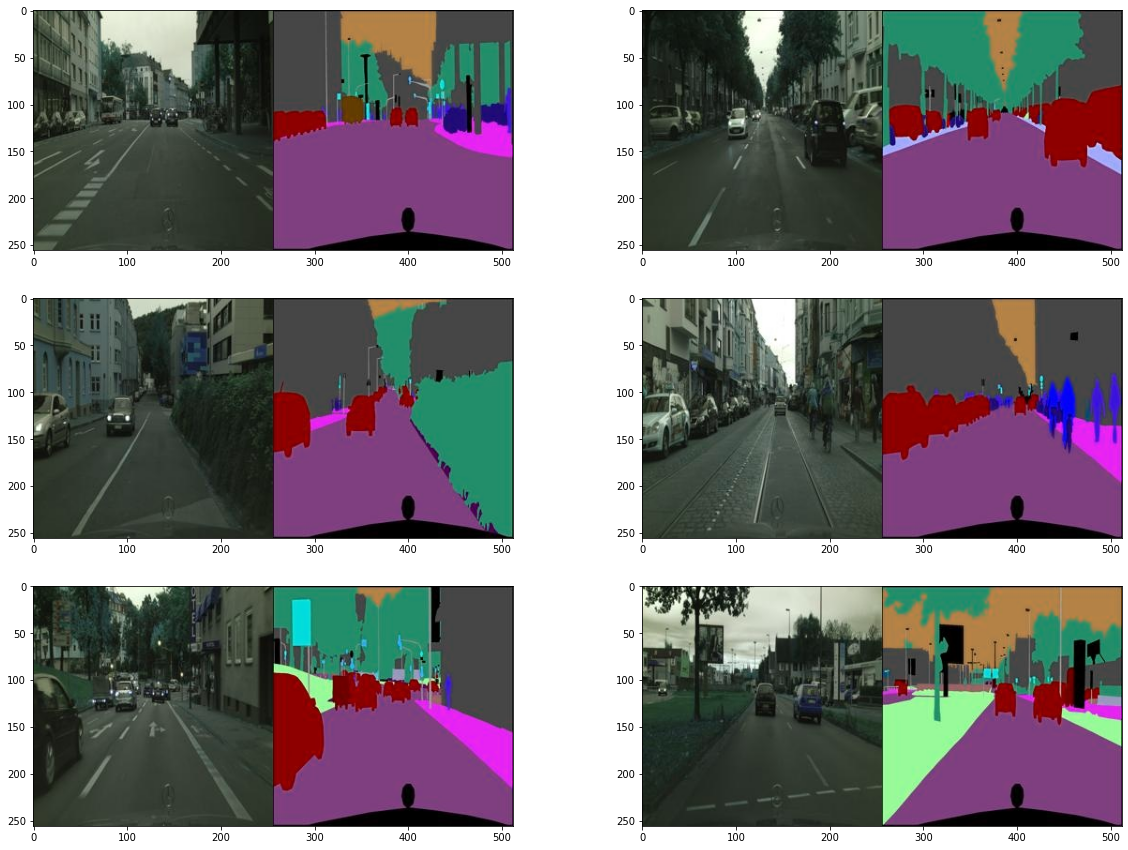

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

data_path = '/content/drive/MyDrive/Colab/Datasets/cityscapes/train/'
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

이 이미지들은 실제 도로 데이터와 세그멘테이션 데이터가 붙은 이미지로 각각 왼쪽과 오른쪽으로 분리하여 이미지를 나누어 사용합니다.

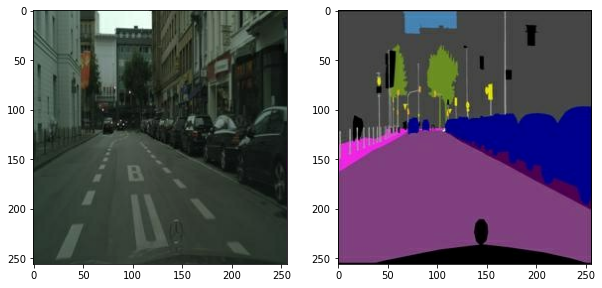

In [8]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    street = img[:, :w, :]
    street = tf.cast(street, tf.float32)
    segmap = img[:, w:, :]
    segmap = tf.cast(segmap, tf.float32)
    return normalize(street), normalize(segmap)

f = data_path + os.listdir(data_path)[1]
street, segmap = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(street))
plt.subplot(1,2,2); plt.imshow(denormalize(segmap))

성공적으로 나누었습니다.  
이 데이터를 Pix2Pix 모델에 입력하여 두번째 사진을 입력하면 첫번째 사진처럼 도로를 그리게 하여야 합니다.  
데이터가 1000개 뿐이니 argumentation으로 학습 데이터를 늘려보겠습니다.

In [9]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(street, segmap):
    stacked = tf.concat([street, segmap], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

사진을 합쳐서 refection패딩 또는 constant 패딩, 256,256,6 랜덤으로 자르기, 50% 확률로 가로로 플립, 50% 확률로 세로로 플립, 50% 확률로 회전을 계속해서 사진에 적용하여 최종 결과를 얻어냅니다.

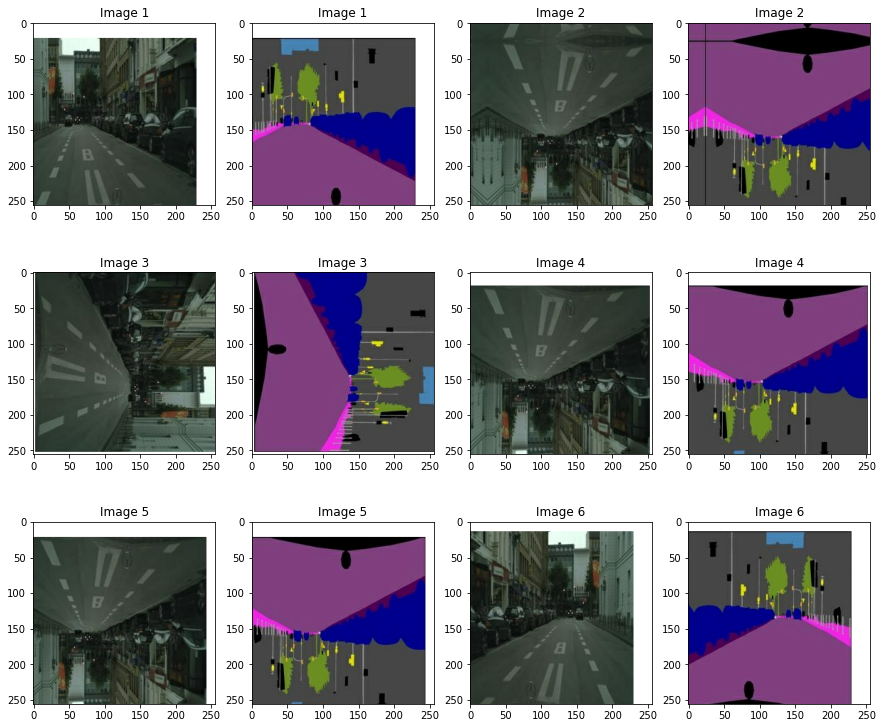

In [11]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_street, augmented_segmap = apply_augmentation(street, segmap)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_street)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_segmap)); plt.title(f"Image {img_n}")
    img_n += 1

다양한 이미지가 생성되었습니다.  
적은 데이터로도 이렇게 많은 데이터를 생성하여 학습을 시킬 수 있습니다.  
이제 해당 내용을 적용해 보겠습니다.

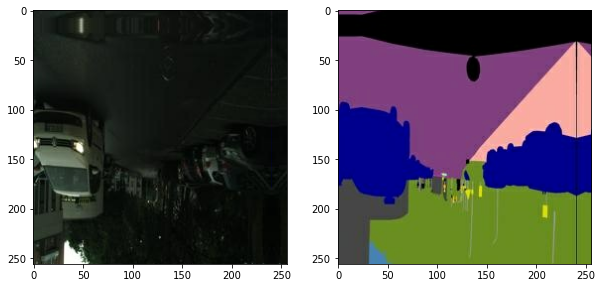

In [12]:
from tensorflow import data

def get_train(img_path):
    street, segmap = load_img(img_path)
    street, segmap = apply_augmentation(street, segmap)
    return street, segmap

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
street, segmap = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(street[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(segmap[0].astype(np.uint8))

## 2. Generator 구성하기  
이제 Generator를 구성해 봅시다.  
Generator는 Encoder와 Decoder 간에 Skip connection이 있는 U-Net Generator를 사용하겠습니다. 

In [14]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

인코더와 디코더의 각 Layer는 위와 같이 인코더는 Conv2D, 디코더는 transposed Conv2D 레이어와 Batch Normalization, Leaky ReLU 활성화 함수를 거칩니다.  
기존의 Generator는 이 레이어를 아래의 그림과 같이 쌓아서 구성합니다. 

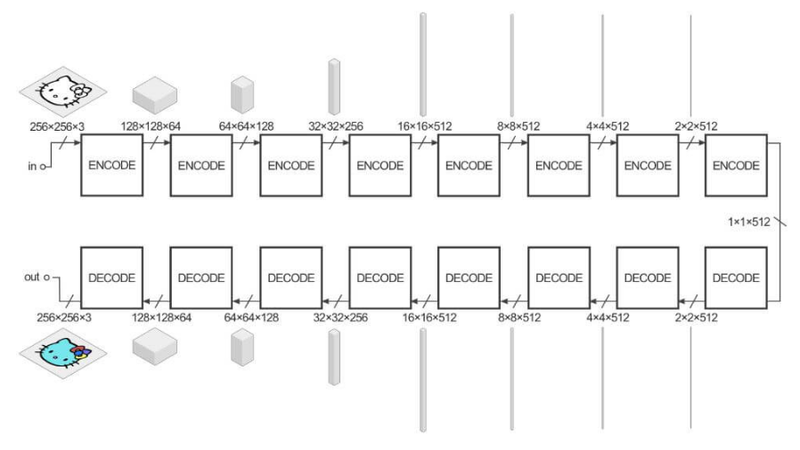

하지만 U-Net Generator의 경우, 디코더 레이어의 입력에 인코더를 연결시켜서 학습합니다.

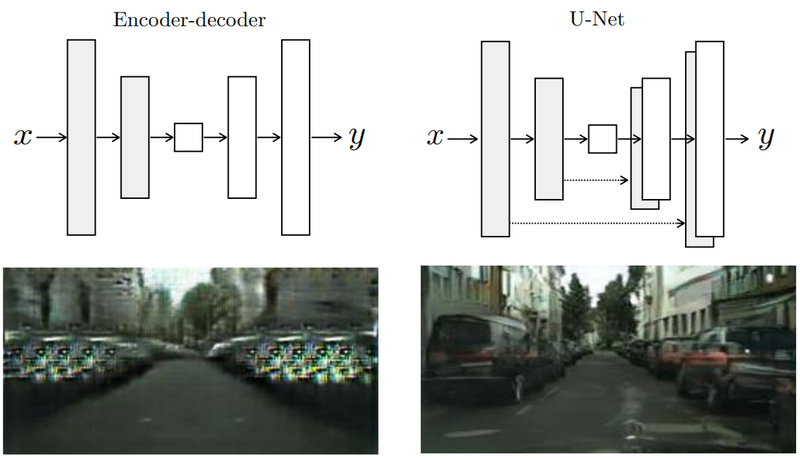

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # 추가된 부분! encoder decoder skip connection을 위한 부분
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
            # feature에 encoder 내에서 사용된 출력들이 저장됨.
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
            # feature 리스트에 있는 각각의 출력들이 decoder 블록 연산 후 concat됨(다음 블록입력으로 사용)
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [17]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

이렇게 5400만개의 파라미터를 가지는 U-Net Generator가 만들어 졌습니다.

## 3. Discriminator 구성하기
Pix2Pix를 완성시키기 위해서는 Discriminator가 필요합니다. 이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 봅시다.  
Discriminator의 구성은 아래와 같습니다.

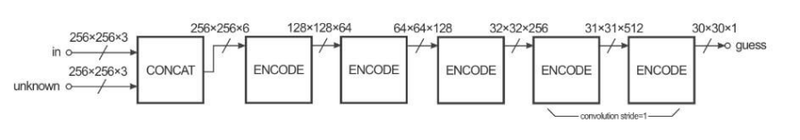

먼저 Discriminator 구성에 사용할 각 레이어를 아래와 같이 생성합니다.

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

init() 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다. 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능합니다.  

In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [21]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

구성에 나왔던 것과 같이 Discriminator를 완성하였습니다.  
잘 동작하는지 한번 확인해 봅시다.

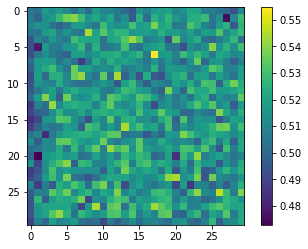

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

정상적으로 30,30 크기의 출력을 냅니다.

## 4. 학습시키기
학습시키기 앞서, 학습에 사용할 손실 함수를 만들어 줍니다.  
손실 함수는 L1 손실 함수와 GAN 손실 함수를 사용하겠습니다.

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

손실 함수를 사용하여 Optimizer도 생성해 줍시다.

In [24]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

이제 하나의 배치 크기를 학습시킬 때의 동작을 함수로 구현합니다.

In [27]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

이제 학습을 시켜보겠습니다. 먼저, 10 에폭으로 학습을 해보겠습니다.

In [28]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (street, segmap) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmap, street)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9310                     
L1_loss:0.3104                     
Discriminator_loss:1.2319

EPOCH[1] - STEP[20]                     
Generator_loss:1.2468                     
L1_loss:0.2250                     
Discriminator_loss:1.5071

EPOCH[1] - STEP[30]                     
Generator_loss:0.8763                     
L1_loss:0.1752                     
Discriminator_loss:1.4126

EPOCH[1] - STEP[40]                     
Generator_loss:0.8834                     
L1_loss:0.2009                     
Discriminator_loss:1.3327

EPOCH[1] - STEP[50]                     
Generator_loss:0.8569                     
L1_loss:0.2019                     
Discriminator_loss:1.3051

EPOCH[1] - STEP[60]                     
Generator_loss:0.9051                     
L1_loss:0.2382                     
Discriminator_loss:1.1214

EPOCH[1] - STEP[70]                     
Generator_loss:0.9694                     
L1_loss:0.2023                    

학습이 끝났다.
val 폴더의 segmap으로 한번 테스트 해보자.

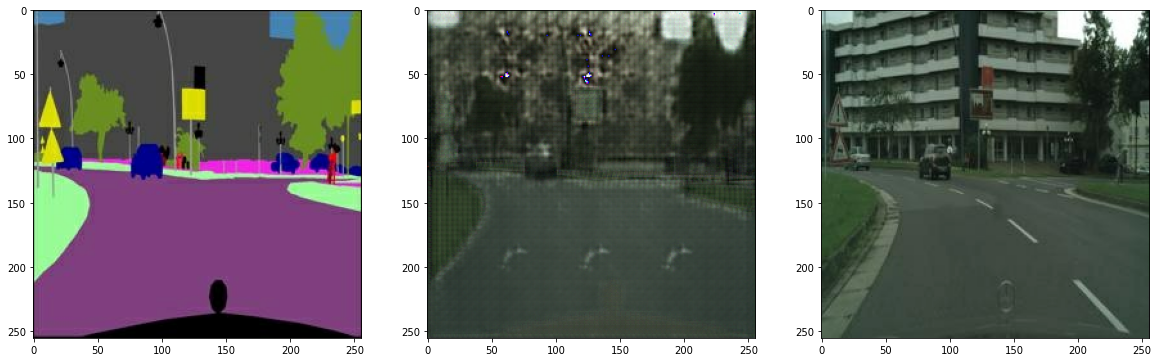

In [33]:
valid_path = '/content/drive/MyDrive/Colab/Datasets/cityscapes/val/'

test_ind = 0

f = data_path + os.listdir(valid_path)[test_ind]
street, segmap = load_img(f)

pred = generator(tf.expand_dims(segmap, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segmap))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(street))

괜찮은듯 하지만 건물쪽이 뭔가 어색하다.
에폭을 늘려서 한번 확인해보자.  
하는김에 loss가 어떻게 바뀌는지도 체크해보자.

In [40]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (street, segmap) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmap, street)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:2.4970                     
L1_loss:0.1656                     
Discriminator_loss:0.9478

EPOCH[1] - STEP[20]                     
Generator_loss:1.7195                     
L1_loss:0.1940                     
Discriminator_loss:0.9115

EPOCH[1] - STEP[30]                     
Generator_loss:1.5018                     
L1_loss:0.1687                     
Discriminator_loss:0.3674

EPOCH[1] - STEP[40]                     
Generator_loss:0.6262                     
L1_loss:0.1580                     
Discriminator_loss:1.0513

EPOCH[1] - STEP[50]                     
Generator_loss:2.0646                     
L1_loss:0.1832                     
Discriminator_loss:0.2461

EPOCH[1] - STEP[60]                     
Generator_loss:0.3409                     
L1_loss:0.1804                     
Discriminator_loss:1.9347

EPOCH[1] - STEP[70]                     
Generator_loss:1.8217                     
L1_loss:0.1594                    

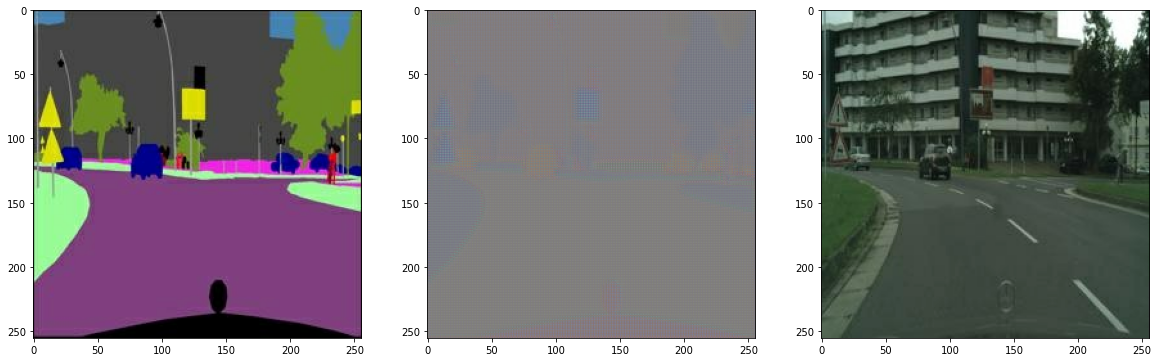

In [41]:
test_ind = 0

f = data_path + os.listdir(valid_path)[test_ind]
street, segmap = load_img(f)

pred = generator(tf.expand_dims(segmap, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segmap))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(street))

에폭을 늘리니 이상하게 나온다.  
10에폭을 돌렸을 때 그나마 알아볼 수 있게 나온다.  
loss는 계속 줄었다 늘었다 한다.

In [42]:
EPOCHS = 5

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (street, segmap) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmap, street)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:2.6112                     
L1_loss:0.1853                     
Discriminator_loss:1.9274

EPOCH[1] - STEP[20]                     
Generator_loss:1.7226                     
L1_loss:0.1671                     
Discriminator_loss:1.6402

EPOCH[1] - STEP[30]                     
Generator_loss:1.1347                     
L1_loss:0.1676                     
Discriminator_loss:1.3685

EPOCH[1] - STEP[40]                     
Generator_loss:1.0614                     
L1_loss:0.1981                     
Discriminator_loss:0.5118

EPOCH[1] - STEP[50]                     
Generator_loss:1.3882                     
L1_loss:0.1641                     
Discriminator_loss:1.1301

EPOCH[1] - STEP[60]                     
Generator_loss:1.0277                     
L1_loss:0.1751                     
Discriminator_loss:0.6914

EPOCH[1] - STEP[70]                     
Generator_loss:2.0214                     
L1_loss:0.1486                    

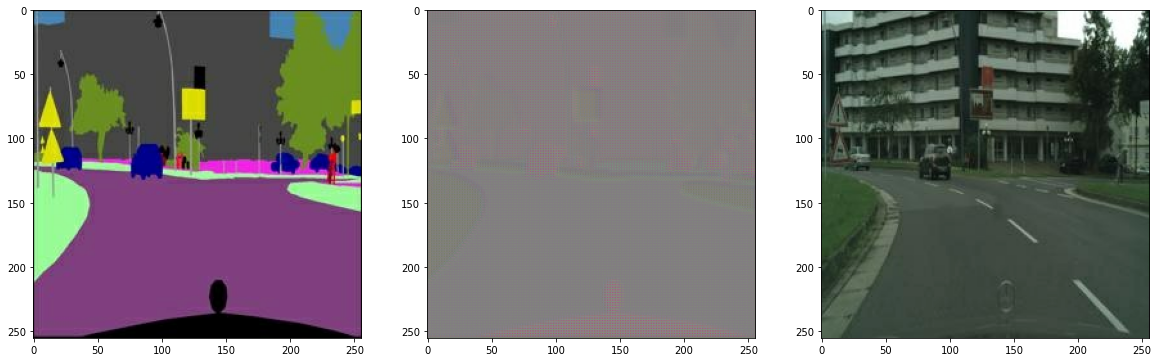

In [43]:
test_ind = 0

f = data_path + os.listdir(valid_path)[test_ind]
street, segmap = load_img(f)

pred = generator(tf.expand_dims(segmap, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segmap))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(street))

In [47]:
EPOCHS = 500

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (street, segmap) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmap, street)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 1000 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

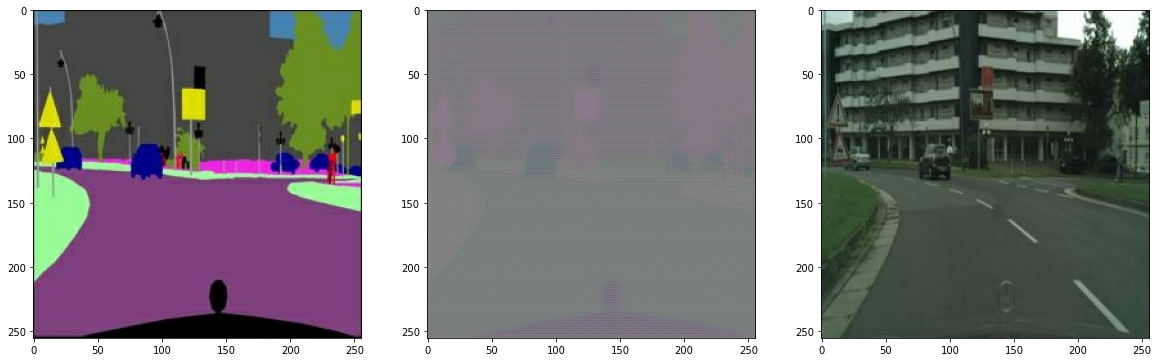

In [48]:
test_ind = 0

f = data_path + os.listdir(valid_path)[test_ind]
street, segmap = load_img(f)

pred = generator(tf.expand_dims(segmap, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segmap))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(street))

3시간에 걸친 긴 학습에도 끄떡하지 않는 모습이다.

## 회고
1. 포켓몬이 더 재밌었는데 아깝다.
2. 코드가 너무 길어서 너무 어지러웠다.
3. 에폭을 늘리면 오히려 사진이 점점 흐릿해진다. 10에폭을 했을 때 제일 잘 나온 것 같다.